In [1]:
import os
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Download the dataset
path = kagglehub.dataset_download("jagdishchakole1/mango-data")
print("Path to dataset files:", path)

# Define data directories
train_dir = os.path.join(path, "Mango_leaf_disease1/train")
val_dir = os.path.join(path, "Mango_leaf_disease1/val")
test_dir = os.path.join(path, "Mango_leaf_disease1/test")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Just rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

100%|██████████| 104M/104M [00:01<00:00, 93.5MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jagdishchakole1/mango-data/versions/1


In [2]:
input_shape = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print("Class mapping:", train_generator.class_indices)

Found 2800 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Number of classes: 8
Class mapping: {'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}


In [3]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.4991 - loss: 1.4427 - val_accuracy: 0.9575 - val_loss: 0.2664 - learning_rate: 1.0000e-04
Epoch 2/20
 1/87 ━━━━━━━━━━━━━━━━━━━━ 1:17 896ms/step - accuracy: 0.8125 - loss: 0.4451

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 253ms/step - accuracy: 0.8125 - loss: 0.4451 - val_accuracy: 0.9575 - val_loss: 0.2631 - learning_rate: 1.0000e-04
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.8996 - loss: 0.3423 - val_accuracy: 0.9712 - val_loss: 0.1382 - learning_rate: 1.0000e-04
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 258ms/step - accuracy: 0.9375 - loss: 0.1804 - val_accuracy: 0.9750 - val_loss: 0.1393 - learning_rate: 1.0000e-04
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9505 - loss: 0.2050 - val_accuracy: 0.9812 - val_loss: 0.0929 - learning_rate: 1.0000e-04
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.9688 - loss: 0.1575 - val_accuracy: 0.9825 - val_loss: 0.0925 - learning_rate: 1.0000e-04
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9538 - loss: 0.1735 - val_accuracy: 0.9812 - val_loss: 0.0784 - learning_rate: 1.0000e-04
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 311ms/step - accuracy: 0.9375 - l

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9972 - loss: 0.0264


Test accuracy: 0.9900


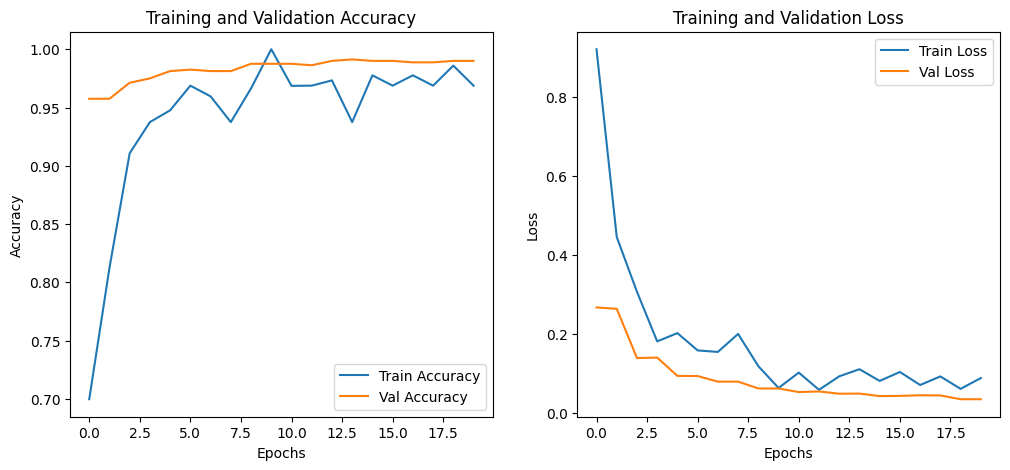

Test accuracy after fine-tuning: 0.9900


In [5]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Save the model
model.save('mango_disease_mobilenet_model.h5')

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

print(f"Test accuracy after fine-tuning: {test_acc:.4f}")